In [3]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
%matplotlib inline
from copy import deepcopy

In [4]:
import gym
import d4rl

No module named 'flow'
No module named 'carla'


# Learning curves / hyperparameter

In [6]:
def get_quantity(name, learner, quantity, smooth=0):
    df = pd.read_csv('logs/' + name + '/' + learner + '.csv')
    x = df['step']
    y = df[quantity]
    y = ewma(y, smooth)
    return x, y

In [7]:
def ewma(array, gamma):
    output = np.zeros_like(array)
    output[0] = array[0]
    for i in range(1, len(array)):
        output[i] = gamma * output[i-1] + (1.0 - gamma) * array[i]
    return output

In [41]:
def learning_curve(env_name, ymin, ymax):

    fig, ax = plt.subplots(1, 4)
    fig.set_size_inches(16, 4)

    #env_name = 'halfcheetah-medium-v2'
    env = gym.make(env_name)
    pi_name = 'pi_reverse_kl'

    seeds = range(3)
    alphas = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]

    width = 1024

    learner = 'pitrain'
    quantity = 'return'

    returns = np.zeros((len(alphas),50,len(seeds)))

    def plot(alg, ax):

        for seed in seeds:
            for i, alpha in enumerate(alphas): # + '-' + str(seed)
                if alg == 'multistep' or alg == 'iterative_init':
                    name = alg + '_' + env_name  + '_' + pi_name + '_alpha_' +\
                            str(alpha) + '_seed_' + str(seed) #+ '_split_True'
                elif alg == 'onestep':
                    name = 'onestep_init_' + pi_name  +\
                            '_alpha_' + str(alpha) + '_' +\
                            env_name + '_seed_' + str(seed) 

                x,y = get_quantity(name, learner, quantity, smooth=0.0)
                returns[i, :, seed] = 100. * env.get_normalized_score(y)

        colors = ['red', 'orange', 'green', 'blue', 'purple', 'grey']
        for i, alpha in enumerate(alphas):  
            ax.plot(x, np.mean(returns[i], axis = -1), label=str(alpha), color = colors[i])
            ax.fill_between(x, y1=np.min(returns[i], axis = -1) , 
                                 y2=np.max(returns[i], axis=-1) , 
                                  alpha=0.3, color=colors[i])

        if alg == 'iterative_init':
            ax.set_title('Iterative')
            ax.set_ylabel('Normalized Return')
        elif alg == 'multistep':
            ax.set_title('Multi-step')
        elif alg == 'onestep':
            ax.set_title('One-step')
            ax.legend(title = 'alpha')
        ax.set_xlabel('Train step')
        ax.set_ylim(ymin, ymax)
        ax.grid()

    algs = ['iterative_init', 'multistep', 'onestep']
    for i, alg in enumerate(algs):
        plot(alg, ax[i])

    algs = [  'iterative', 'multistep', 'onestep']

    hyper_dict = {
        'pi_reverse_kl': {'alpha': [0.03, 0.1,  0.3, 1.0, 3.0, 10.0]},
        'pi_marwil': {'temp': [0.1, 0.3, 1.0, 3.0, 10.0, 30.0]},
        'pi_easy_bcq': {'n': [2, 5, 10, 20, 50, 100]},
        'beta': {'n': [1]}
    }


    means = np.zeros((3, 6))
    stds = np.zeros((3, 6))

    for i, alg_name in enumerate(algs):
        seeds = [0,1,2]
        ave_returns = []
        for s in seeds:
            returns_dict = torch.load('results/' + alg_name + '_' + pi_name + '_' + env_name + '_' + str(s))
            hyper_list = list(hyper_dict[pi_name].values())[0]
            mean_s = []
            for h in hyper_list:
                mean_s.append(100 * np.mean(returns_dict[str(h)]))
            ave_returns.append(mean_s)

        # n_seeds * n_hyperparams
        ave_returns = np.array(ave_returns)

        means[i] = np.mean(ave_returns, axis=0)
        stds[i] = np.std(ave_returns, axis=0)

        colors = [ 'cyan', 'magenta', 'black',]
        labels = ['Iterative', 'Multi-step', 'One-step']
        ax[-1].plot(alphas, means[i], label=labels[i], color = colors[i])
        ax[-1].fill_between(alphas, y1=np.min(ave_returns, axis = 0) , 
                             y2=np.max(ave_returns, axis=0) , 
                              alpha=0.3, color=colors[i])

    ax[-1].set_ylim(ymin, ymax)
    ax[-1].set_xscale('log')
    ax[-1].legend()
    ax[-1].set_xlabel('alpha')
    #ax[-1].set_ylabel('Normalized return')
    ax[-1].set_title('Final Performance')

    fig.suptitle(env_name, fontsize="x-large", y=0.07)
    plt.tight_layout()
    plt.savefig('figures/lc-' + env_name + '.png', dpi=300)
    plt.show()

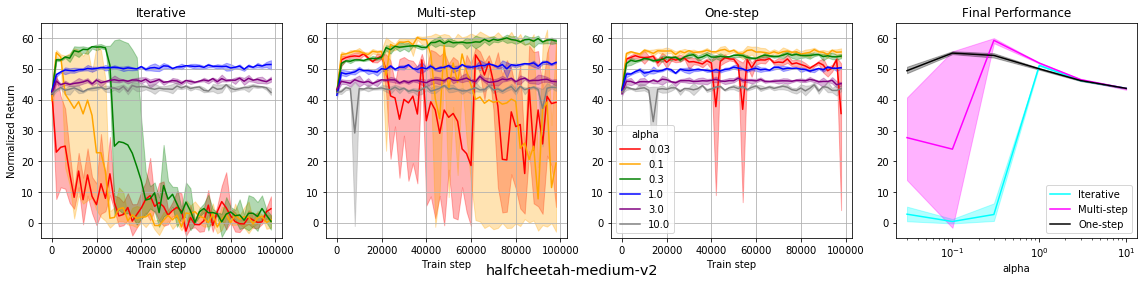

In [42]:
learning_curve('halfcheetah-medium-v2', -5, 65)

# MSE vs KL

In [88]:
def load_mse_data(q_type, env_name,
                     rollout_policy_type, rollout_step, alpha, seed, N, n_rolls):
    if q_type == 'qseed':
        data_dict = torch.load('data/rollouts/' + env_name + '_eval_' + 
                            rollout_policy_type + '_' + str(rollout_step) + 
                            '_alpha_' + str(alpha) + '_seed_' + str(seed) + '_N_' + str(N) + 
                               '_' + str(n_rolls) + '_qseed_' + str(seed))
    else:
        data_dict = torch.load('data/rollouts/' + env_name + '_' + q_type + '_' + 
                            rollout_policy_type + '_' + str(rollout_step) + 
                            '_alpha_' + str(alpha) + '_seed_' + str(seed) + '_N_' + str(N) + '_' + str(n_rolls))
    return data_dict['qvals'], data_dict['rollouts']

In [89]:
steps = range(0, 55000, 5000)
alphas = [0.1, 0.3, 1.0]
seeds = range(3)
env_name = 'halfcheetah-medium-v2'
q_type = 'eval'

N = 1000
n_rolls = 3

rolls = np.zeros((2, len(alphas), len(steps), len(seeds), N, n_rolls))
qs = np.zeros((2, len(alphas), len(steps), len(seeds), N))

for k, policy_type in enumerate([ 'iterative']):
    for j, alpha in enumerate(alphas):
        for i, step in enumerate(steps):
            for seed in seeds:
                qvals, rollouts = load_mse_data(q_type, env_name,
                                         policy_type, step, alpha, seed, N, n_rolls)

                rolls[k, j, i, seed, :] = rollouts
                qs[k, j, i, seed, :] = qvals
                
kls = np.zeros((2, len(alphas), len(steps), len(seeds)))


for k, policy_type in enumerate([ 'iterative_init_']):
    for j, alpha in enumerate(alphas):
        for i, step in enumerate(steps):
            for seed in seeds:
                name = policy_type + env_name + '-' + str(seed) + '_pi_reverse_kl_alpha_' +\
                            str(alpha) + '_seed_' + str(seed)
                x,y = get_quantity(name, 'pitrain', 'kl')
                idx1 = np.where(x == step)[0]
                idx2 = np.where(x == step  - 1000)[0]
                idx = np.concatenate([idx1, idx2])
                kls[k, j,i,seed] = y[idx]

99


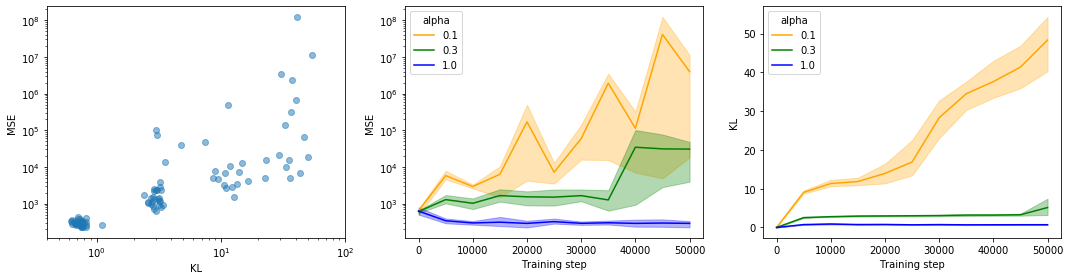

In [90]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 4)


mse = np.mean((np.mean(rolls, axis = -1) - qs)**2, axis = -1)

mse = mse[0].flatten()
kl = kls[0].flatten()
print(len(mse))

ax[0].scatter(kl, mse, alpha=0.5)
#plt.ylim(1e2, 1e6)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(0.4, 100)
ax[0].set_xlabel('KL')
ax[0].set_ylabel('MSE')

mse = np.mean((np.mean(rolls, axis = -1) - qs)**2, axis = -1)

# avg over data seed
iterative = 0
mean_mse = np.mean(mse, axis = -1)[iterative]

kl = np.mean(kls, axis = -1)[iterative]


colors = ['orange', 'green', 'blue',  'purple', 'grey','red', ]
for i, alpha in enumerate(alphas):
    ax[1].plot(steps, mean_mse[i], label=str(alpha), color = colors[i])
    ax[1].fill_between(steps, y1=np.min(mse[iterative, i], axis = -1) , 
                         y2=np.max(mse[iterative, i], axis=-1) , 
                          alpha=0.3, color=colors[i])

#plt.ylim(1e2, 1e8)
ax[1].set_yscale('log')
ax[1].set_xlabel('Training step')
ax[1].set_ylabel('MSE')
ax[1].legend(title = 'alpha')


for i, alpha in enumerate(alphas):
    ax[2].plot(steps, kl[i], label=str(alpha), color = colors[i])
    ax[2].fill_between(steps, y1=np.min(kls[iterative, i], axis = -1) , 
                         y2=np.max(kls[iterative, i], axis=-1) , 
                          alpha=0.3, color=colors[i])

ax[2].set_xlabel('Training step')
ax[2].set_ylabel('KL')
ax[2].legend(title = 'alpha')

#ax[2].set_yscale('log')
#ax[2].set_ylim(0.4, 100)

plt.tight_layout()
plt.savefig('figures/mse vs kl.png', dpi=300)
plt.show()

# Overestimation

In [180]:
steps = range(0, 50000, 10000)
#alphas = [0.1, 0.3, 1.0]
seeds = range(3)
rollout_policy_type = 'iterative'
env_name = 'halfcheetah-medium-v2'
alpha = 0.1

def load_rolls(q_type):

    N = 1000
    n_rolls = 3

    rolls = np.zeros(( len(steps), len(seeds), N, n_rolls))
    qs = np.zeros(( len(steps), len(seeds), N))

    bias = np.zeros(( len(steps), len(seeds)))
    mse = np.zeros(( len(steps), len(seeds)))

    improvement = np.zeros(( len(steps), len(seeds)))

    for i, step in enumerate(steps):
        for seed in seeds:
            qvals, rollouts = load_mse_data(q_type, env_name,
                                     rollout_policy_type, step, alpha, seed, N, n_rolls)

            rolls[ i, seed, :] = rollouts
            qs[ i, seed, :] = qvals
    return rolls, qs

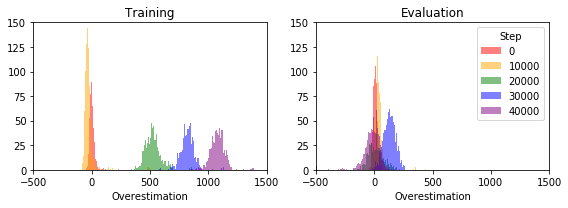

In [181]:
eval_rolls, eval_qs = load_rolls('eval')
train_rolls, train_qs = load_rolls('train')

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 3) 

overs = (train_qs - np.mean(train_rolls, axis=-1))[ :, 2, :]
#overs = np.mean(train_qs - np.mean(train_rolls, axis=-1), axis=-2)

overs = np.minimum(overs, 1500)
overs = np.maximum(overs, -500)


colors = ['red','orange', 'green', 'blue',  'purple', 'grey', 'cyan', 'magenta', 'black', 'yellow']
for i in range(len(steps)):
    ax[0].hist(overs[i], label = steps[i], bins=100, alpha=0.5, color=colors[i])

ax[0].set_ylim(0,150)
ax[0].set_xlim(-500,1500)
ax[0].set_title('Training')
ax[0].set_xlabel('Overestimation')



overs = (eval_qs - np.mean(eval_rolls, axis=-1))[ :, 2, :]
#overs = np.mean(eval_qs - np.mean(eval_rolls, axis=-1), axis=-2)

overs = np.minimum(overs, 1500)
overs = np.maximum(overs, -500)

for i in range(len(steps)):
    ax[1].hist(overs[i], label = steps[i], bins=100, alpha=0.5, color=colors[i])

ax[1].set_ylim(0,150)
ax[1].set_xlim(-500,1500)
ax[1].set_title('Evaluation')
ax[1].set_xlabel('Overestimation')
ax[1].legend(title='Step')


plt.tight_layout()
plt.savefig('figures/histograms.png', dpi=300)
plt.show()

# Between random and medium

In [228]:
def get_returns(alg_name, env_name):
    
    pi_name = 'pi_reverse_kl'
    hyper_list = list(hyper_dict[pi_name].values())[0]
    
    
    ave_returns = np.zeros((len(seeds), len(hyper_list)))
    for s in seeds:
        returns_dict = torch.load('results/' + alg_name + '_' + pi_name + '_' + env_name + '_' + str(s))
        mean_s = []
        for h in hyper_list:
            mean_s.append(100 * np.mean(returns_dict[str(h)]))
        ave_returns[s] = np.array(mean_s)
    idx = np.argmax(np.mean(ave_returns, axis = 0))
    return ave_returns[:, idx]
        
seeds = [0,1,2]


ps =  [0.1, 0.2, 0.4, 0.6, 0.8] 
hyper_dict = {'pi_reverse_kl': {'alpha': [0.1,  0.3, 1.0, 3.0, 10.0]},}
it_final_returns = np.zeros((len(ps) + 2, len(seeds)))
it_final_returns[0] = get_returns('iterative', 'halfcheetah-random-v2')
it_final_returns[-1] = get_returns('iterative', 'halfcheetah-medium-v2')
for i, p in enumerate(ps):
    it_final_returns[i+1] = get_returns('iterative', 'halfcheetah-random-v2-halfcheetah-medium-v2-' + str(p))
    

hyper_dict = {'pi_reverse_kl': {'alpha': [0.1,  0.3, 1.0, 3.0]},}
onestep_final_returns = np.zeros((len(ps) + 2, len(seeds)))
onestep_final_returns[0] = get_returns('onestep', 'halfcheetah-random-v2')
onestep_final_returns[-1] = get_returns('onestep', 'halfcheetah-medium-v2')
for i, p in enumerate(ps):
    onestep_final_returns[i+1] = get_returns('onestep', 'halfcheetah-random-v2-halfcheetah-medium-v2-' + str(p))


hyper_dict = {'pi_reverse_kl': {'alpha': [0.1,  0.3, 1.0, 3.0, 10.0]},}
mu_final_returns = np.zeros((len(ps) + 2, len(seeds)))
mu_final_returns[0] = get_returns('multistep', 'halfcheetah-random-v2')
mu_final_returns[-1] = get_returns('multistep', 'halfcheetah-medium-v2')
for i, p in enumerate(ps):
    mu_final_returns[i+1] = get_returns('multistep', 'halfcheetah-random-v2-halfcheetah-medium-v2-' + str(p))


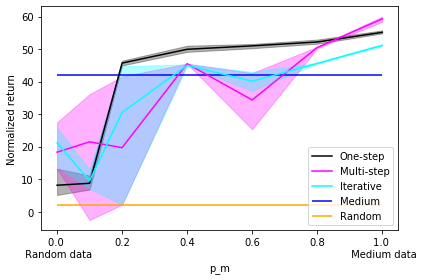

In [229]:
fig.set_size_inches(4, 3) 

ps = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0] 
plt.plot(ps, np.mean(onestep_final_returns, axis=-1), label='One-step', color = 'black')
plt.fill_between(ps, y1=np.min(onestep_final_returns, axis = -1) , 
                         y2=np.max(onestep_final_returns, axis=-1) , 
                          alpha=0.3, color='black')

 
plt.plot(ps, np.mean(mu_final_returns, axis=-1), label='Multi-step', color = 'magenta')
plt.fill_between(ps, y1=np.min(mu_final_returns, axis = -1) , 
                         y2=np.max(mu_final_returns, axis=-1) , 
                          alpha=0.3, color='magenta')


plt.plot(ps, np.mean(it_final_returns, axis=-1), label='Iterative', color = 'cyan')
plt.fill_between(ps, y1=np.min(it_final_returns, axis = -1) , 
                         y2=np.max(it_final_returns, axis=-1) , 
                          alpha=0.3, color='cyan')





plt.hlines(41.9, 0,1 , label='Medium', color = 'blue')
plt.hlines( 2.2, 0,1, label='Random', color = 'orange')

ps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0] 
plt.xlabel('p_m')
plt.xticks(ticks = ps, labels = ['0.0 \n Random data', 0.2, 0.4, 0.6, 0.8, '1.0 \n Medium data'])
plt.ylabel('Normalized return')
plt.legend()

plt.tight_layout()
plt.savefig('figures/r-m_mixture.png', dpi=300)

plt.show()

# Appendix learning curves

In [33]:
env_dict = {
        'halfcheetah-medium-v2': [-5, 65],
        'halfcheetah-medium-expert-v2': [-5, 100],
        'halfcheetah-random-v2': [-5, 40],
            'walker2d-medium-v2': [-5, 95], 
            'walker2d-medium-expert-v2': [-5, 120], 
            'walker2d-random-v2': [-5, 25], 
            'hopper-medium-v2': [-5, 105], 
            'hopper-medium-expert-v2': [-5, 120],
            'hopper-random-v2':[-5, 35]
}

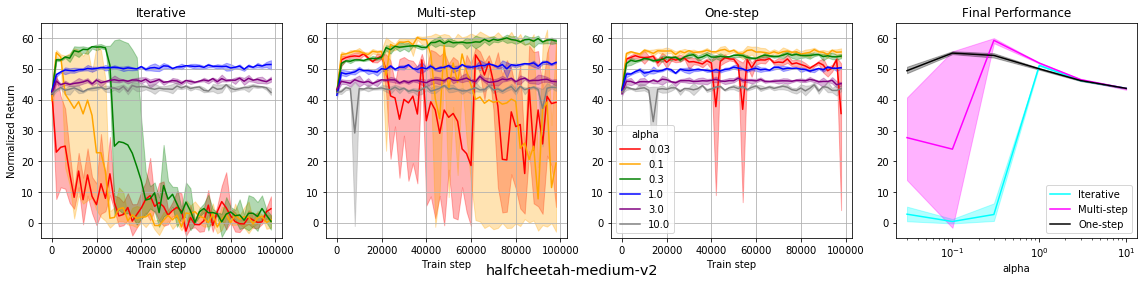

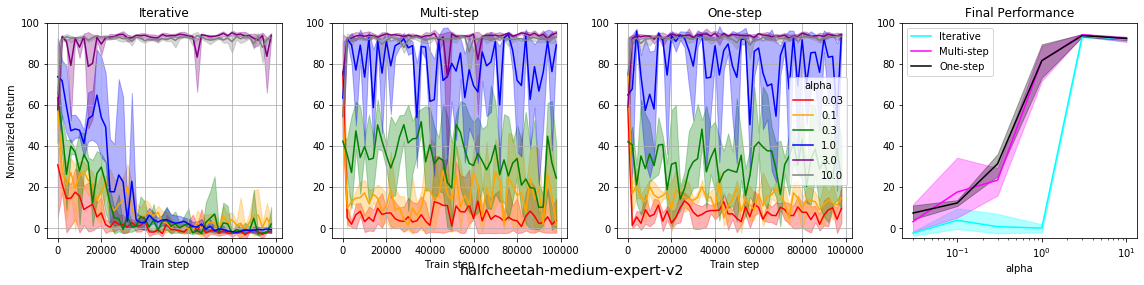

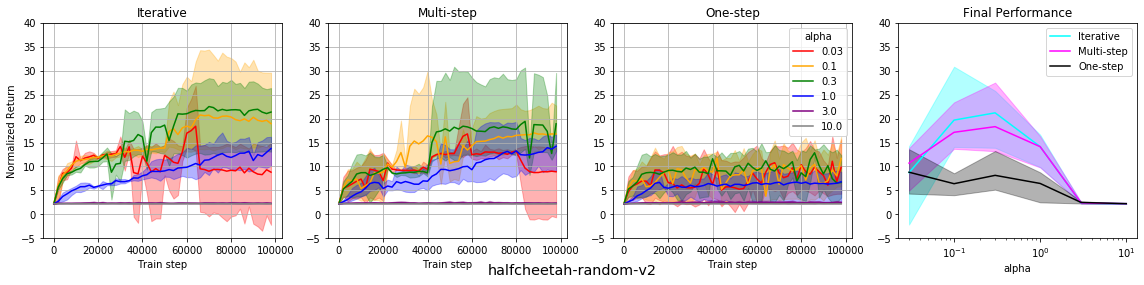

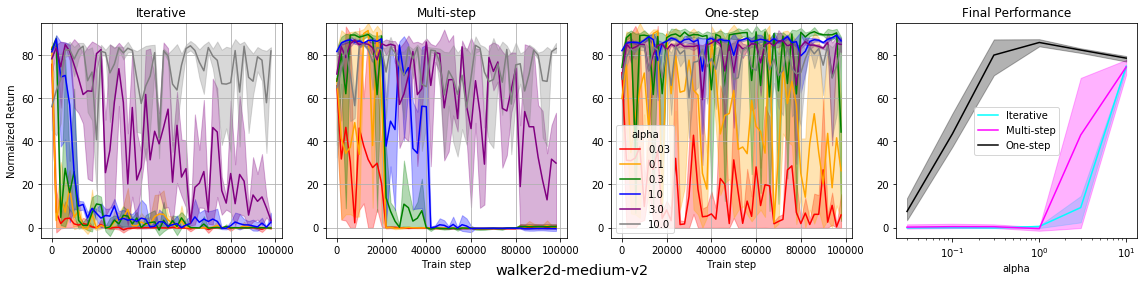

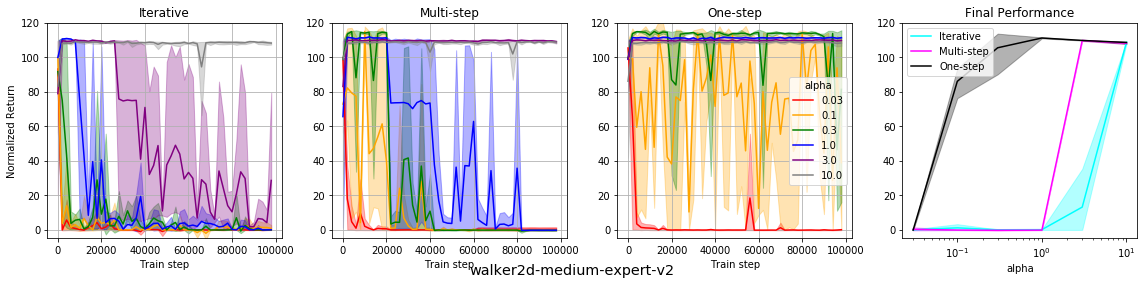

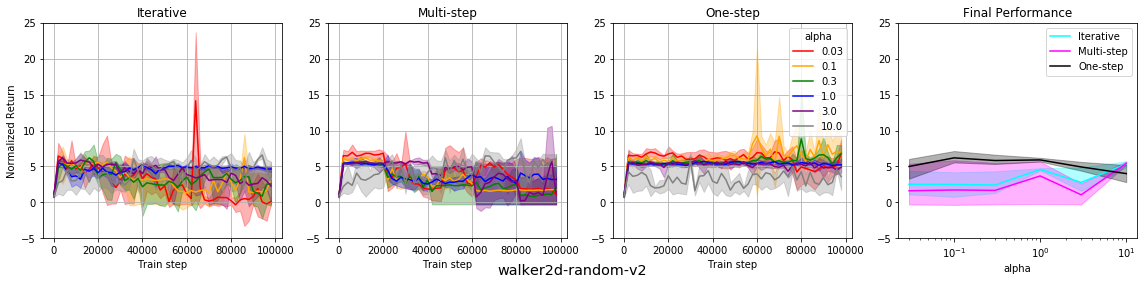

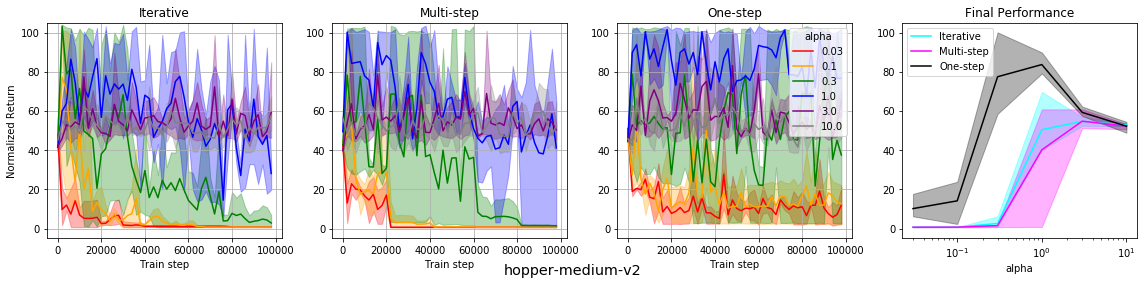

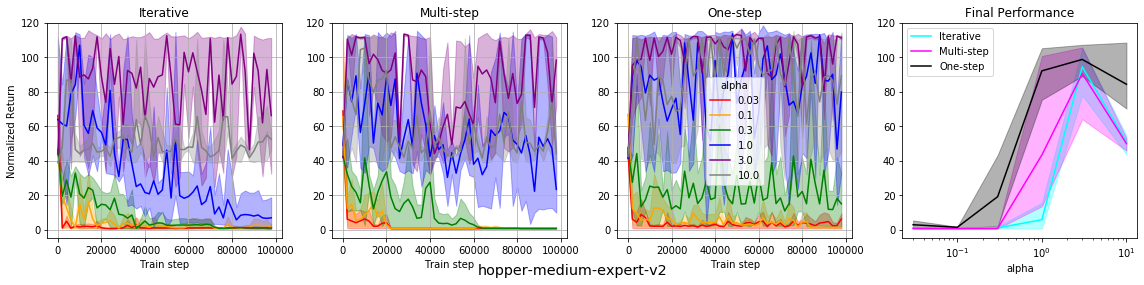

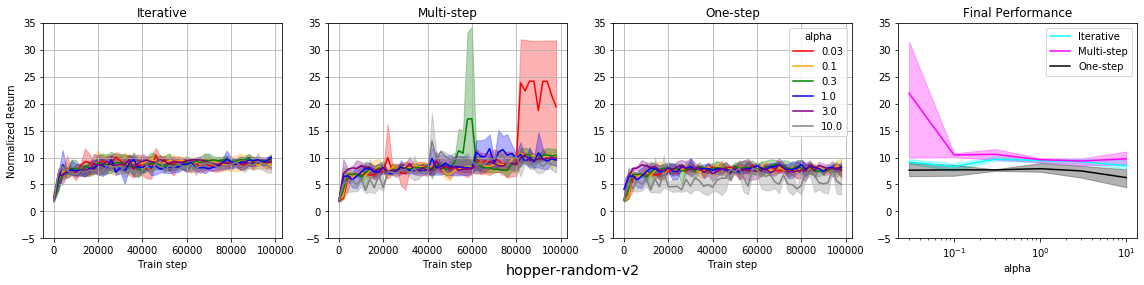

In [43]:
for env_name, ylims in env_dict.items():
    learning_curve(env_name, ylims[0], ylims[1])